# ACP sur l'ensemble des variables encodées

**Imports et chargement données**

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FDS = pd.read_csv("FDS_clean.csv")

**ACP**

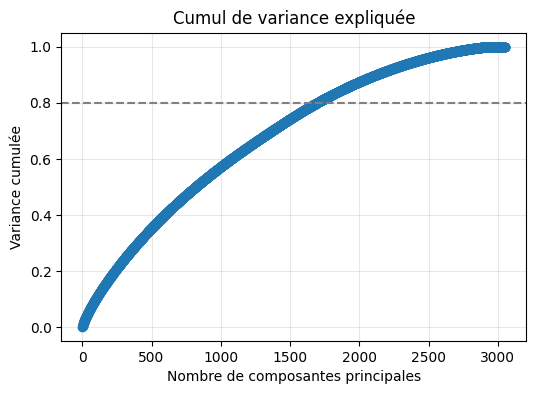

📌 1695 composantes expliquent ≥ 80 % de la variance.


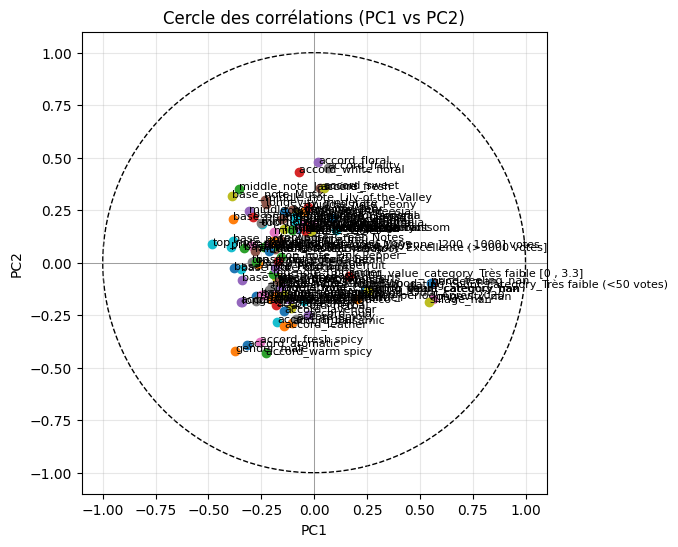

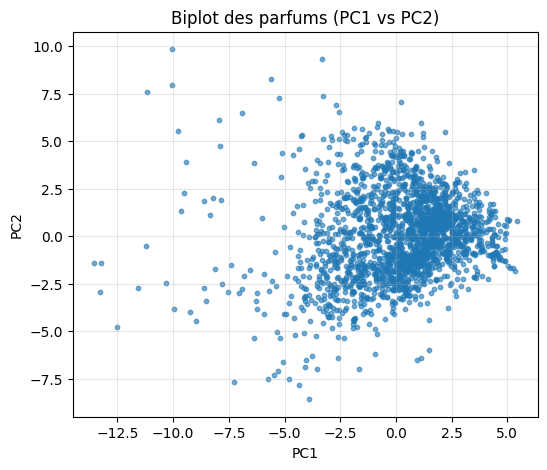

In [7]:

# --- 2.0 Sélection des colonnes à inclure -----------------
# Sélectionner uniquement les colonnes numériques
X = FDS.select_dtypes(include=[np.number])

# ➜ Facultatif : retirer Rating_value et Rating_count
#    si vous voulez qu'ils servent plus tard de "targets"
X = X.drop(columns=["rating_value", "rating_count"])

# On remplace les valeurs manquantes par la moyenne de chaque colonne CE NEST PAS TOUJOURS
# RECOMMANDÉ, mais ici on le fait pour simplifier l'exemple.
X = X.fillna(X.mean())

# --- 2.1 Centrage-réduction -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2.2 ACP ----------------------------------------------
pca = PCA()                       # on garde toutes les composantes
X_pca = pca.fit_transform(X_scaled)

# --- 2.3 Variance expliquée cumulée -----------------------
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.axhline(0.80, linestyle="--", color="grey")
plt.title("Cumul de variance expliquée")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance cumulée")
plt.grid(alpha=.3)
plt.show()

n80 = np.argmax(cum_var >= 0.80) + 1
print(f"📌 {n80} composantes expliquent ≥ 80 % de la variance.")

# --- 2.4 Cercle des corrélations (PC1 vs PC2) -------------
#    => on affiche seulement les variables dont |loading| > seuil
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
pc1, pc2 = loadings[:,0], loadings[:,1]

threshold = 0.15                        # ajustez pour plus/moins de points
mask = (np.abs(pc1) > threshold) | (np.abs(pc2) > threshold)
vars_kept = X.columns[mask]

plt.figure(figsize=(6,6))
plt.axhline(0, color="grey", lw=.5)
plt.axvline(0, color="grey", lw=.5)
circle = plt.Circle((0,0), 1, facecolor="none", edgecolor="black", linestyle="--")
plt.gca().add_patch(circle)

for i, var in enumerate(vars_kept):
    plt.plot(pc1[mask][i], pc2[mask][i], 'o')
    plt.text(pc1[mask][i], pc2[mask][i], var, fontsize=8)

plt.title("Cercle des corrélations (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(alpha=.3)
plt.show()

# --- 2.5 Biplot PC1-PC2 (sur un échantillon pour la lisibilité) ---
sample = X_pca[:2000]          # ou un échantillon aléatoire
plt.figure(figsize=(6,5))
plt.scatter(sample[:,0], sample[:,1], s=10, alpha=.6)
plt.title("Biplot des parfums (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=.3)
plt.show()

# --- 2.6 Matrice compacte prête pour le clustering --------
n_components = n80             # ou moins si vous préférez
X_pca80 = X_pca[:, :n_components]

# Sauvegarde pour la suite
np.save("X_PCA80.npy", X_pca80)
